# Jane Street Market Prediction (#5.1)
## Principal Component Analysis

Loaded by [#5.3](https://www.kaggle.com/wendellavila/janestreet-dimensionality-reduction)

Notebook Navigation<br>
[All](https://www.kaggle.com/wendellavila/janestreet-index/) | [#1](https://www.kaggle.com/wendellavila/janestreet-model-selection/) | [#2.1](https://www.kaggle.com/wendellavila/janestreet-preprocessing-selection) | [#2.2](https://www.kaggle.com/wendellavila/janestreet-data-preprocessing) | [#3](https://www.kaggle.com/wendellavila/janestreet-regularization-selection) | [#4.1](https://www.kaggle.com/wendellavila/janestreet-hyperparameter-tuning) | [#4.2](https://www.kaggle.com/wendellavila/janestreet-hyperparameter-evaluation) | [#5.1](https://www.kaggle.com/wendellavila/janestreet-pca) | [#5.2](https://www.kaggle.com/wendellavila/janestreet-autoencoder) | [#5.3](https://www.kaggle.com/wendellavila/janestreet-dimensionality-reduction-evaluation) |[#6](https://www.kaggle.com/wendellavila/janestreet-ensemble)

## Imports

In [1]:
#import janestreet
import os
import glob
import IPython

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 150)
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import load_model
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Loading and scaling data

In [2]:
#data loaded from another notebook
#already preprocessed and downsized for faster loading
#https://www.kaggle.com/code/wendellavila/janestreet-data-preprocessing/
train_data = pd.read_pickle('../input/janestreet-data-preprocessing/train-mean-indicator.pkl')
val_data = pd.read_pickle('../input/janestreet-data-preprocessing/val-mean-indicator.pkl')
features = [col for col in train_data.columns if 'feature' in col]
resp_cols = [col for col in train_data.columns if 'resp' in col]

In [3]:
X_train = train_data.loc[:, features].values
X_val = val_data.loc[:, features].values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
del scaler

## Misc

In [4]:
#downsizing dataframe for faster loading
def reduce_dtypes(df):
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    return df

## PCA Explained Variance Analysis

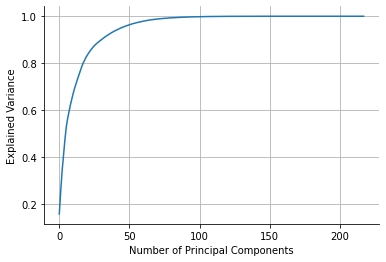

In [5]:
pca = PCA()
comp = pca.fit(X_train)
plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine();
plt.savefig('pca-explained_variance_ratio.png', dpi=300, transparent=True)
del pca, comp
#using 80 components

## PCA

In [6]:
n_comp = 80
pca = PCA(n_components=n_comp).fit(X_train)
train_pca = pd.DataFrame(pca.transform(X_train))
val_pca = pd.DataFrame(pca.transform(X_val))

In [7]:
pca_col = ['feature_pca_'+str(i+1) for i in range(n_comp)]
train_pca.columns = pca_col
val_pca.columns = pca_col

train_pca['date'] = train_data['date'].values
train_pca['weight'] = train_data['weight'].values
train_pca['resp'] = train_data['resp'].values
train_pca['resp_1'] = train_data['resp_1'].values
train_pca['resp_2'] = train_data['resp_2'].values
train_pca['resp_3'] = train_data['resp_3'].values
train_pca['resp_4'] = train_data['resp_4'].values
train_pca['action'] = train_data['action'].values
val_pca['date'] = val_data['date'].values
val_pca['weight'] = val_data['weight'].values
val_pca['resp'] = val_data['resp'].values
val_pca['resp_1'] = val_data['resp_1'].values
val_pca['resp_2'] = val_data['resp_2'].values
val_pca['resp_3'] = val_data['resp_3'].values
val_pca['resp_4'] = val_data['resp_4'].values
val_pca['action'] = val_data['action'].values

train_pca = reduce_dtypes(train_pca)
val_pca = reduce_dtypes(val_pca)

train_pca.to_pickle(f'train-pca.pkl')
val_pca.to_pickle(f'val-pca.pkl')